In [2]:
using Gadfly
using Compose
using DataFrames

Взаимная информация:
\begin{equation}
I_m = -\sum_rP[s]\log_2P [s] + \sum_{r,s}P[r]P[s|r]\log_2 P[s|r]
\end{equation}


\begin{equation}
I_m = \sum_{s,r}P[r,s]\log_2\frac{P[r,s]}{P[r]P[s]}
\end{equation}

In [3]:
# 1 синапс на нейрон
function model_Hnoise(s,p;Ntrials=1e6)
    responses = zeros(2,2)
    for i =1:Ntrials
        if rand() < s # spike arrived
            row = 2
            col = if rand() < p 2 else 1 end
        else row,col = 1,1 end
        responses[row, col] +=1
    end
    probs =  responses/Ntrials
    Prs = sum(probs, 1)
    Pss = sum(probs, 2)
    acc = 0
    for row in [1,2]
        for col in [1,2]
            Prs_joint = probs[row,col]
            # skipping zero probabilities to avoid numerical errors...
            if Prs_joint*Prs[col]*Pss[row] > 0
                acc += Prs_joint*log2(Prs_joint/(Prs[col]*Pss[row]))
            end
        end
    end
    Iinp = -sum(Pss.*log2(Pss))
    return acc/Iinp # доля переданной информации!
    #return acc
    
end

model_Hnoise (generic function with 1 method)

In [5]:
model_Hnoise(0.5,0.9;Ntrials=1e7)

0.7583149796325215

In [6]:
sx = 0.01
pv = linspace(0.01,1.0)
sv = [0.01, 0.1, 0.5, 0.95, 0.99]
@time yx = [[model_Hnoise(s,p, Ntrials=1e7) for p in pv] for s in sv];

 20

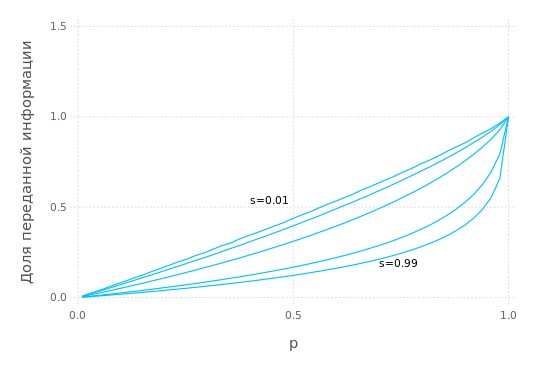

.923645 seconds (32.00 k allocations: 1.253 MB)


In [7]:
layers = [layer(x=pv, y=y, Geom.line) for y in yx]
pl2 = plot(layers...,
           Guide.xlabel("p"), Guide.ylabel("Доля переданной информации"),
           Guide.annotation(compose(context(), 
                                   (context(), text(0.4, 0.5, "s=0.01")),
                                   (context(), text(0.7, 0.15, "s=0.99")))))

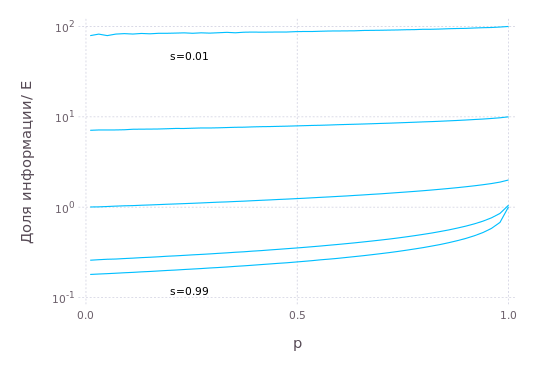

In [8]:
layers2 = [layer(x=pv, y=(y./(s.*pv)), Geom.line,) for (y,s) in zip(yx,sv) ]
pl3 = plot(layers2...,
 Scale.y_log10,
Guide.xlabel("p"), Guide.ylabel("Доля информации/ E"),
           Guide.annotation(compose(context(), 
                                   (context(), text(0.2, 1.6, "s=0.01")),
                                   (context(), text(0.2, -1, "s=0.99")))))

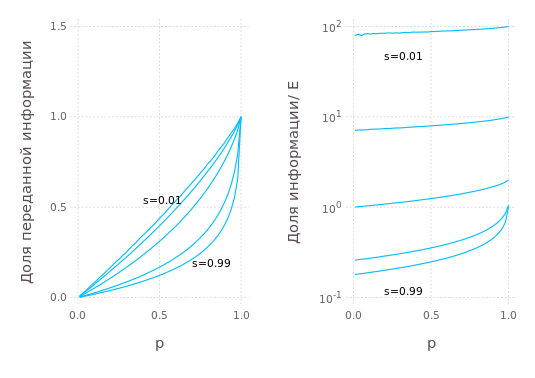

In [9]:
pl_stack1 = hstack(pl2, pl3)